In [ ]:
import tensorflow as tf
import numpy as np
import pickle

In [ ]:
company_name = 'jnj'

In [ ]:
class HyperParams:
    num_words = 92
    num_docs = 50
    sequence_len = 10
    batch_size = 16
    vocab_size = 252911
    embedded_size = 256
    num_units_bi_gru_1 = 128
    num_units_main_gru = 512
    num_units_main_gru_2 = 128
    num_units_post_dense_1 = 300
    num_units_post_dense_2 = 64
    num_output = 1
    validation_steps = 5
    auxiliary_x = 6

    lr = 1e-05
    fine_tune_epochs = 30
    fine_tune_batch_size = 16
    auto_tune = tf.data.experimental.AUTOTUNE
    opt = tf.keras.optimizers.Adam(lr)
    loss = tf.keras.losses.MeanSquaredError()
    epochs = 100
    metrics = ['mean_absolute_error', 'mean_squared_error', 'mean_squared_logarithmic_error']
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='min',
                                          patience=10)
    r = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                             factor=0.8,
                                             patience=2,
                                             verbose=1,
                                             mode='auto',
                                             epsilon=0.0001,
                                             cooldown=5,
                                             min_lr=0.00001)


def tri_attention_rnn_model(plot_model=True,
                            summary_model=True):
    word_input = tf.keras.Input(shape=HyperParams.num_words,
                                dtype='int64',
                                name='word_input')

    # Embedding layer
    word_embedding = tf.keras.layers.Embedding(input_dim=HyperParams.vocab_size,
                                               output_dim=HyperParams.embedded_size)(word_input)
    bi_gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_bi_gru_1,
                                                                 return_sequences=True))(word_embedding)
    # the first attention layer to capture the word-level attentions
    attention_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_bi_gru_1 * 2,
                                              activation='tanh')(bi_gru_1)
    attention_softmax_1 = tf.keras.layers.Activation('softmax')(attention_dense_1)
    attention_mul_1 = tf.keras.layers.multiply([attention_softmax_1, bi_gru_1])
    vec_sum_1 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_1)
    word_level_model = tf.keras.Model(inputs=word_input,
                                      outputs=vec_sum_1)

    doc_input = tf.keras.Input(shape=(HyperParams.num_docs, HyperParams.num_words),
                               dtype='int64',
                               name='doc_input')
    post_bi_gru_1 = tf.keras.layers.TimeDistributed(word_level_model)(doc_input)

    # the second attention layer to capture the news-level attentions
    attention_dense_2 = tf.keras.layers.Dense(HyperParams.num_units_bi_gru_1 * 2,
                                              activation='tanh')(post_bi_gru_1)
    attention_softmax_2 = tf.keras.layers.Activation('softmax')(attention_dense_2)
    attention_mul_2 = tf.keras.layers.multiply([attention_softmax_2, post_bi_gru_1])
    vec_sum_2 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_2)
    doc_level_model = tf.keras.Model(inputs=doc_input, outputs=vec_sum_2)

    seq_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words),
                               dtype='int64',
                               name='seq_input')

    # Incorporating the auxiliary variables
    auxiliary_input = tf.keras.Input(shape=(HyperParams.sequence_len, HyperParams.auxiliary_x),
                                     dtype='float32',
                                     name='auxiliary_input')
    pre_main_gru = tf.keras.layers.TimeDistributed(doc_level_model)(seq_input)
    pre_main_gru_concat = tf.keras.layers.concatenate([pre_main_gru, auxiliary_input], axis=-1)
    main_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru,
                                                                 return_sequences=True))(pre_main_gru_concat)
    main_gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(HyperParams.num_units_main_gru_2,
                                                                   return_sequences=True))(main_gru)

    # the third attention layer to capture the time-level attentions
    attention_dense_3 = tf.keras.layers.Dense(HyperParams.num_units_main_gru_2 * 2,
                                              activation='tanh')(main_gru_2)
    attention_softmax_3 = tf.keras.layers.Activation('softmax')(attention_dense_3)
    attention_mul_3 = tf.keras.layers.multiply([attention_softmax_3, main_gru_2])
    vec_sum_3 = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(attention_mul_3)

    # Passing through multiple FC layers
    main_dense_1 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_1,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(vec_sum_3)
    main_dropout_1 = tf.keras.layers.Dropout(0.1)(main_dense_1)
    main_dense_2 = tf.keras.layers.Dense(HyperParams.num_units_post_dense_2,
                                         activation='tanh',
                                         kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,
                                                                                        l2=0.00001))(main_dropout_1)
    main_dropout_2 = tf.keras.layers.Dropout(0.1)(main_dense_2)
    output = tf.keras.layers.Dense(HyperParams.num_output,
                                   activation=None)(main_dropout_2)

    model = tf.keras.Model(inputs=[seq_input, auxiliary_input], outputs=output)

    if plot_model:
        tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
    if summary_model:
        print(model.summary())
    return model

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 10, 50, 92)] 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 10, 256)      65173248    seq_input[0][0]                  
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 10, 262)      0           time_distributed_5[0][0]         
                                                                 auxiliary_input[0][0]      

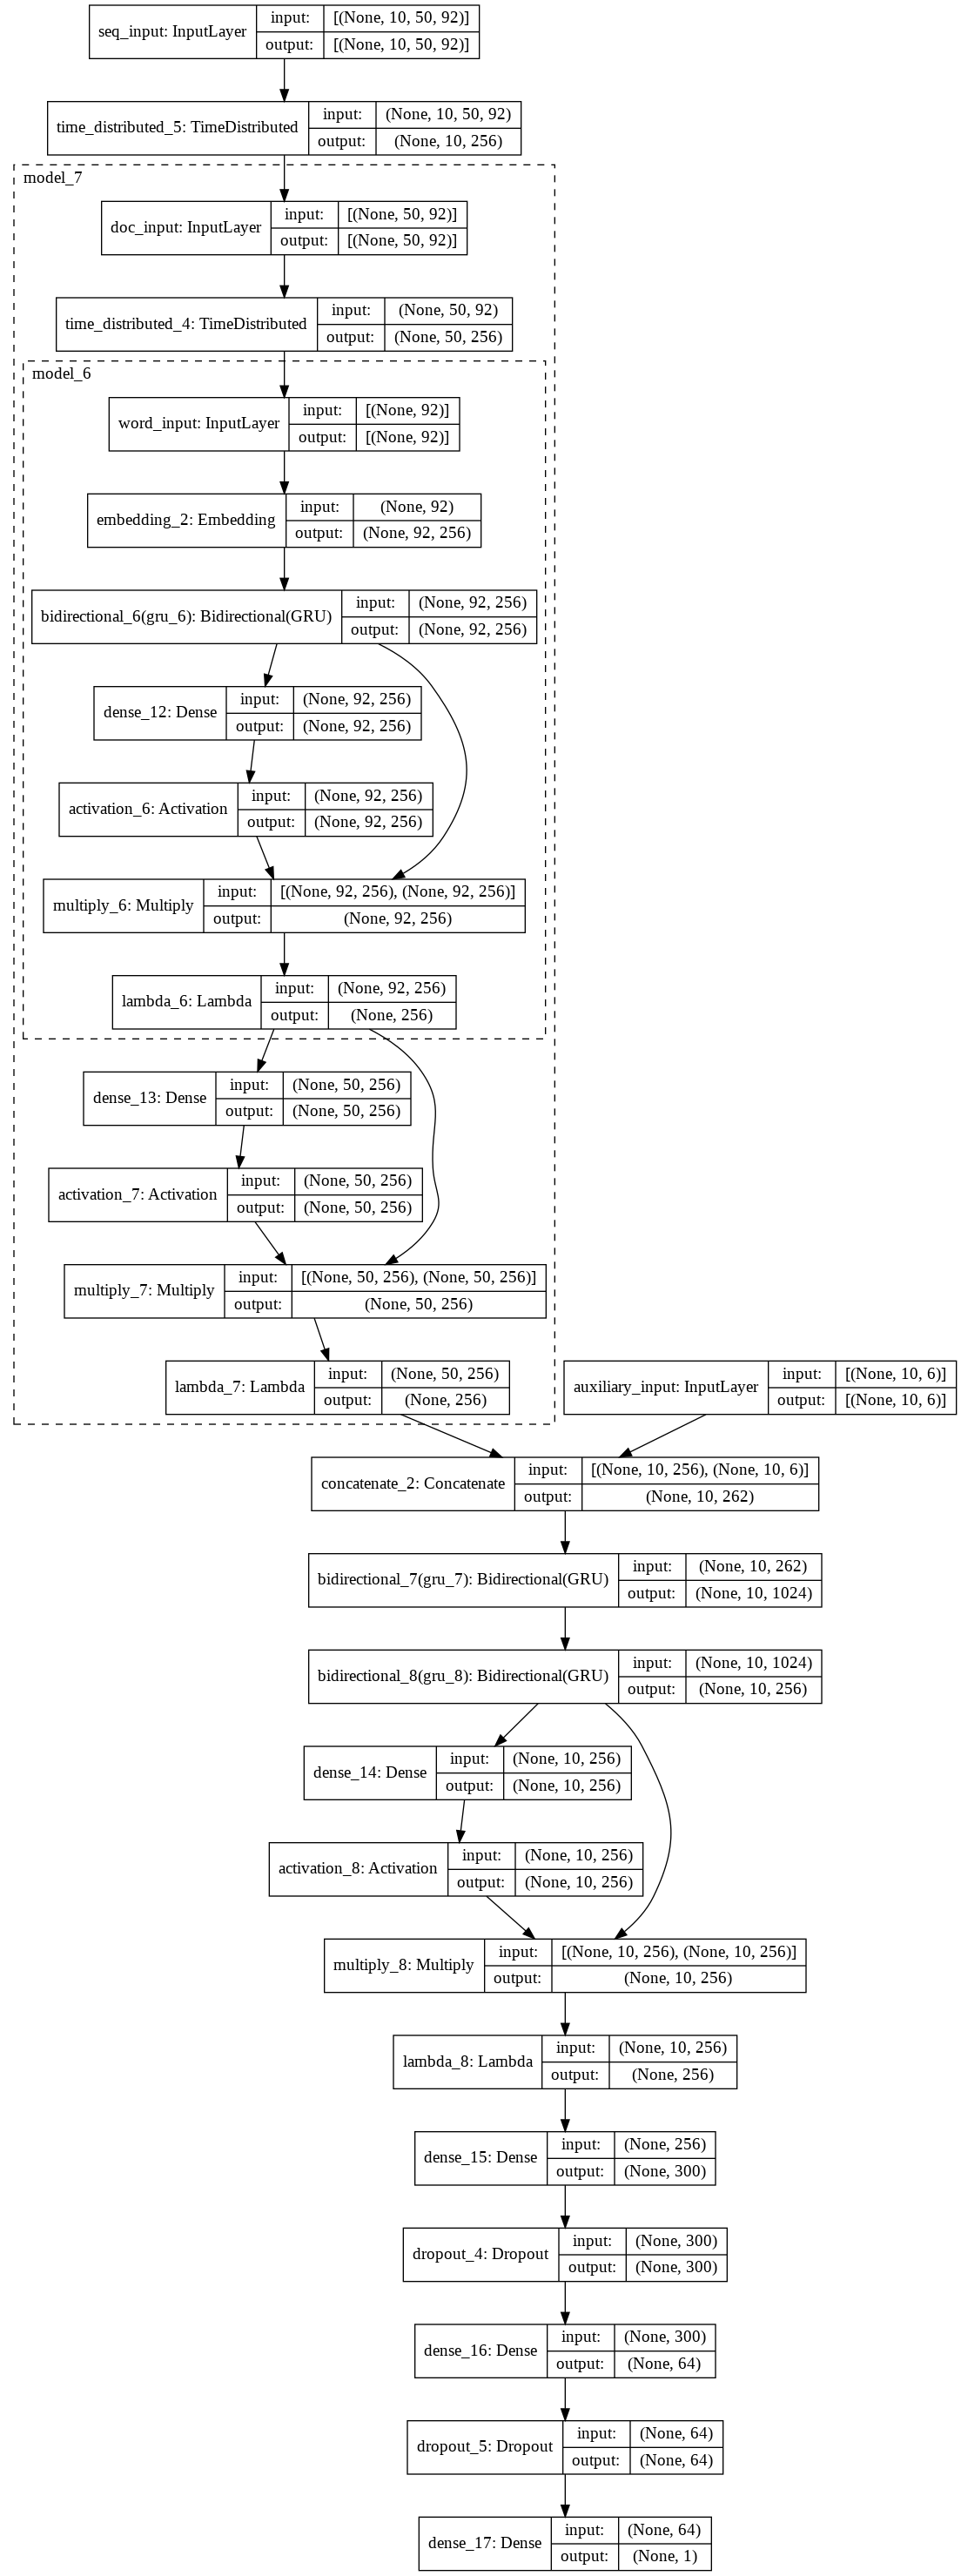

In [ ]:
m = tri_attention_rnn_model()
m.compile(optimizer=HyperParams.opt, loss=HyperParams.loss, metrics=HyperParams.metrics)
tf.keras.utils.plot_model(m, show_shapes=True, expand_nested=True)

In [ ]:
def parse_data(x):
    description = {'x1': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'x2': tf.io.FixedLenFeature([], tf.string, default_value=''),
                   'y': tf.io.FixedLenFeature([], tf.float32, default_value=-1)}
    parsed_features = tf.io.parse_single_example(x, description)
    x1 = tf.io.decode_raw(parsed_features['x1'], 'int64')
    x1 = tf.reshape(x1, [HyperParams.sequence_len, HyperParams.num_docs, HyperParams.num_words])

    x2 = tf.io.decode_raw(parsed_features['x2'], 'float32')
    x2 = tf.reshape(x2, [HyperParams.sequence_len, HyperParams.auxiliary_x])

    y = parsed_features['y']

    return x1, x2, y


def load_data(file):
    df = tf.data.TFRecordDataset(file)
    df = df.map(parse_data)
    return df


def save_obj(obj, name):
    """
    :param obj:
    :param name:
    :return:
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    """
    :param name:
    :return:
    """
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


def get_train_data(train_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(train_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df


def get_valid_data(valid_fn, batch_size: int = HyperParams.batch_size):
    df = load_data(valid_fn)
    df = df.repeat().shuffle(64).batch(batch_size).prefetch(HyperParams.auto_tune)
    return df

In [ ]:
df_train = get_train_data('/content/drive/MyDrive/2040 final/2040 final proj/{}_train.tfrecords'.format(company_name))
df_validation = get_valid_data('/content/drive/MyDrive/2040 final/2040 final proj/{}_validation.tfrecords'.format(company_name))

In [ ]:
def get_train_size(dir, n_max=10000):
    df = load_data(dir)
    df = df.batch(1).prefetch(HyperParams.auto_tune)
    s = 0
    for i, j, k in df.take(n_max):
        s += 1
    return s


n_train = get_train_size('/content/drive/MyDrive/2040 final/2040 final proj/{}_train.tfrecords'.format(company_name))
print('IN ALL {} TRAINING SAMPLES.'.format(n_train))

IN ALL 5175 TRAINING SAMPLES.


In [ ]:
def train_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)


def validation_generator(df):
    for i, j, k in df.as_numpy_iterator():
        yield ([i, j], k)

In [ ]:
tg = train_generator(df_train)
vg = validation_generator(df_validation)

In [ ]:
history_m = m.fit(tg, validation_data=vg, batch_size=HyperParams.batch_size, epochs=HyperParams.epochs, steps_per_epoch=n_train//HyperParams.batch_size, validation_steps=HyperParams.validation_steps, callbacks=[HyperParams.es, HyperParams.r])
m.save('/content/drive/MyDrive/2040 final/2040 final proj/model_{}.h5'.format(company_name))
save_obj(history_m.history, '/content/drive/MyDrive/2040 final/2040 final proj/model_{}_hist'.format(company_name))

Epoch 1/100
323/323 [==============================] - 374s 1s/step - loss: 0.4270 - mean_absolute_error: 0.5913 - mean_squared_error: 0.3712 - mean_squared_logarithmic_error: 0.2098 - val_loss: 0.0580 - val_mean_absolute_error: 0.0447 - val_mean_squared_error: 0.0023 - val_mean_squared_logarithmic_error: 8.5285e-04
Epoch 2/100
158/323 [=============>................] - ETA: 3:01 - loss: 0.0607 - mean_absolute_error: 0.0582 - mean_squared_error: 0.0051 - mean_squared_logarithmic_error: 0.0019

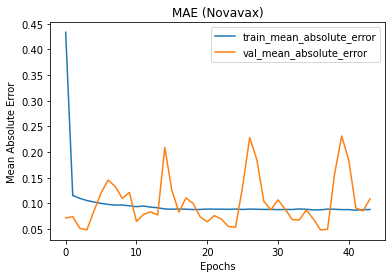

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_m4.history['mean_absolute_error'] + history_m4_finetune.history['mean_absolute_error'], label='train_mean_absolute_error')
plt.plot(history_m4.history['val_mean_absolute_error'] + history_m4_finetune.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('MAE ({})'.format(company_name))
plt.legend()
plt.show()

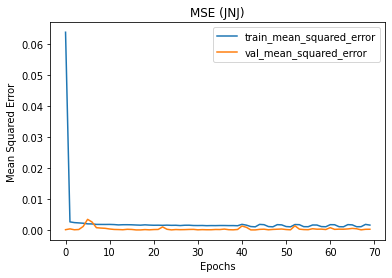

In [ ]:
plt.plot(history_m4['mean_squared_error'] + history_m4_finetune.history['mean_squared_error'], label='train_mean_squared_error')
plt.plot(history_m4['val_mean_squared_error'] + history_m4_finetune.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE ({}))'.format(company_name))
plt.legend()
plt.show()

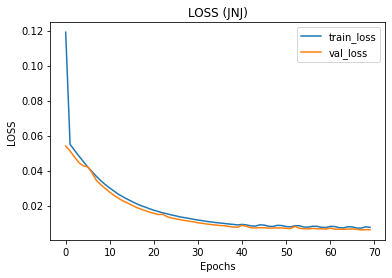

In [ ]:
plt.plot(history_m4['loss'] + history_m4_finetune.history['loss'], label='train_loss')
plt.plot(history_m4['val_loss'] + history_m4_finetune.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.title('LOSS ({}})'.format(company_name))
plt.legend()
plt.show()